# 実機での実行

ベル状態を作成し、IBMの量子コンピューターで実行します。

In [1]:
# Qiskitライブラリーを導入
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService

ベル状態を作成します。

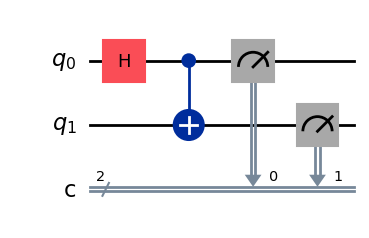

In [2]:
qc = QuantumCircuit(2,2)
qc.h(0) 
qc.cx(0,1) 
qc.measure(0, 0)
qc.measure(1, 1)
qc.draw(output="mpl")

まずはシミュレーターで実験してみます。

{'11': 508, '00': 516}


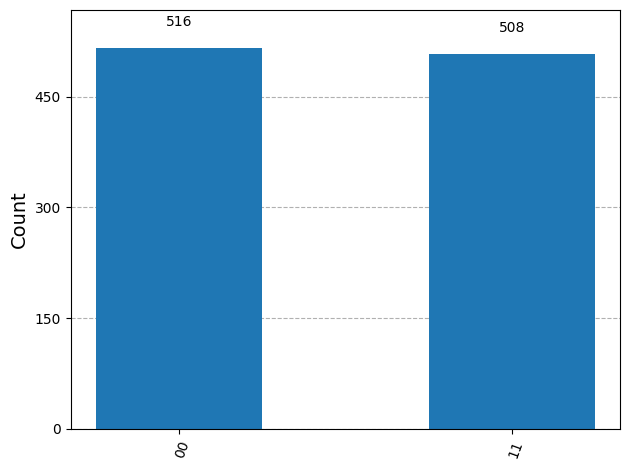

In [3]:
# シミュレーターで実験
backend = AerSimulator()
sampler = Sampler(backend)
job = sampler.run([qc])
result = job.result()

#  測定された回数を表示
counts = result[0].data.c.get_counts()
print(counts)

# ヒストグラムで測定された確率をプロット
plot_histogram( counts )

## 実機で実行する

実量子コンピューターで実験するため次の手順で、API keyとCRNを次のセルのコードに入力してください。 

1) https://quantum.cloud.ibm.com/ にサインインし、左側 「API key」の横にある「Create +」をクリックします。
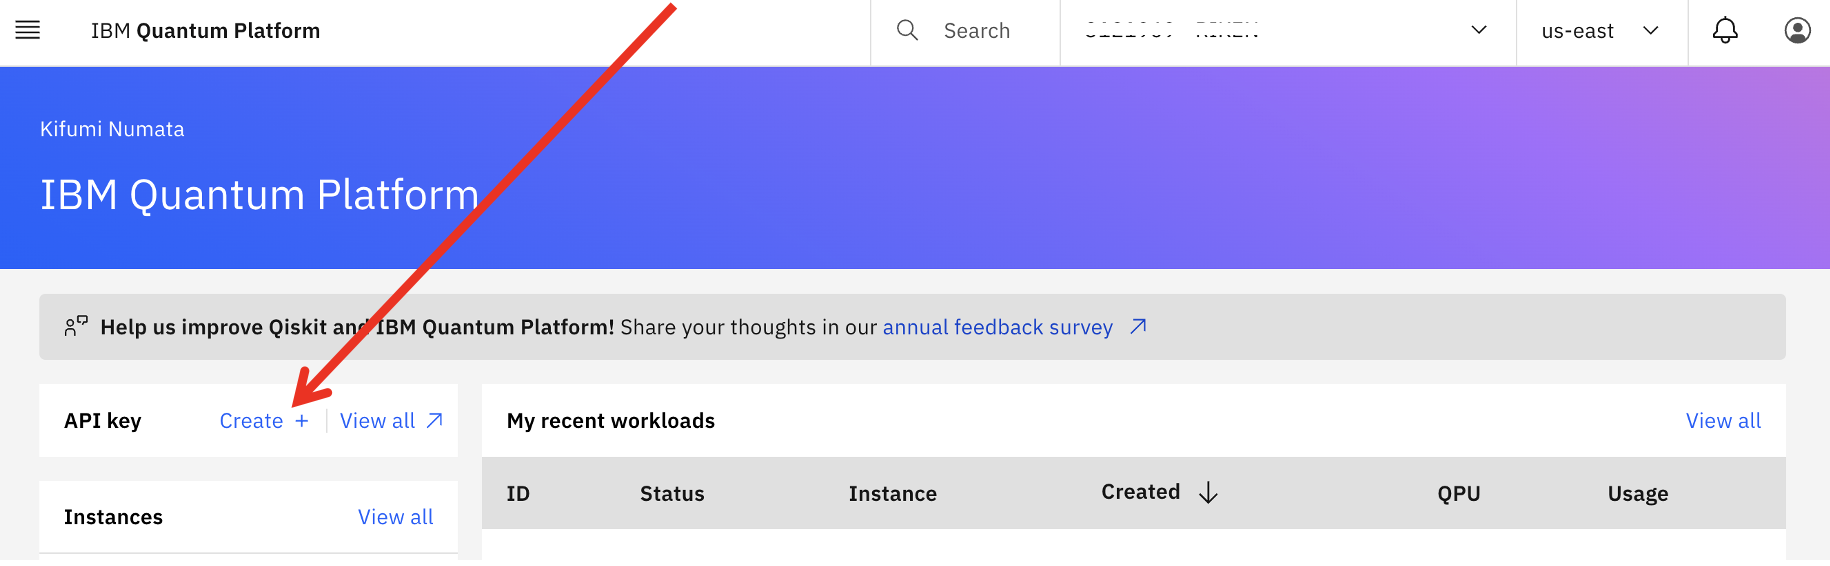

2) API keyの名前（例：my API など）を自由に入力し、「Create」をクリックします。
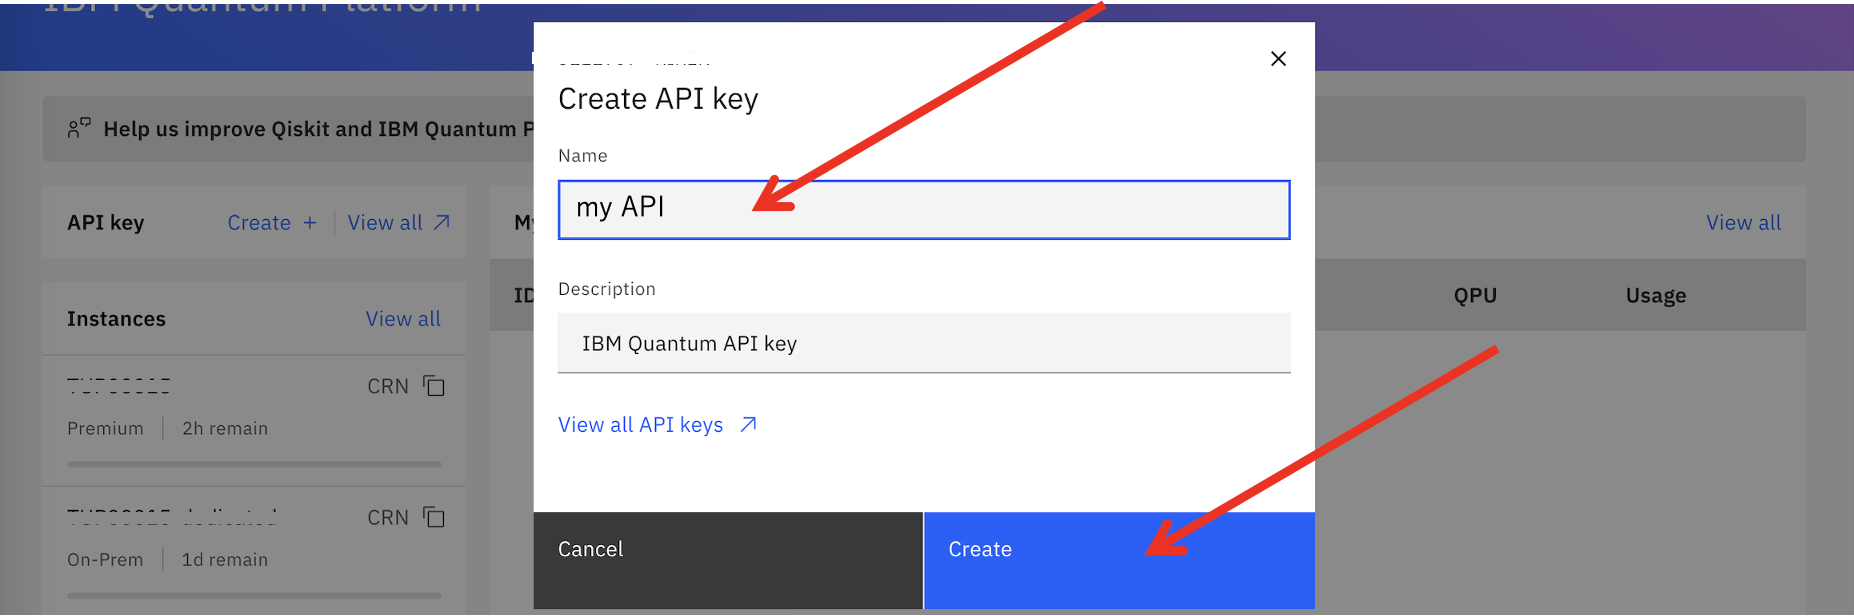

3) 「Download」をクリックして「apikey.json」ファイルを保存します。
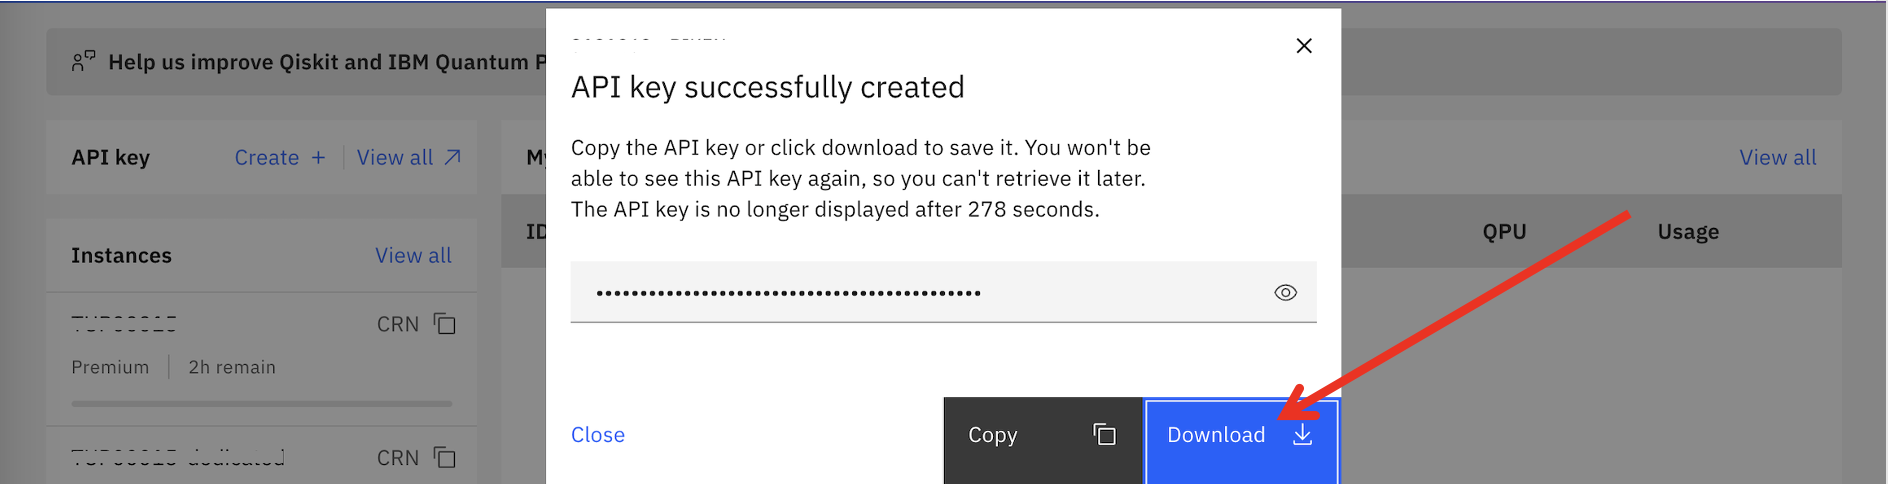

4) 先ほど保存した「apikey.json」ファイルから、apikeyをコピーして、次のセルの `deleteThisAndPasteYourAPIKeyHere` に上書きしてください。
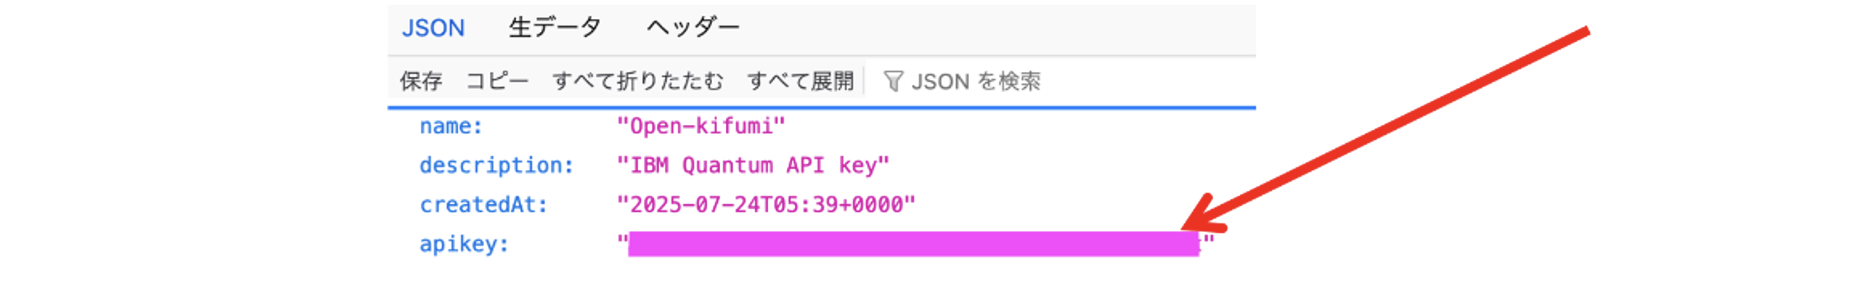

5) CRNをコピーして、次のセルの `deleteThisAndPasteYourCRNHere` に上書きしてください。
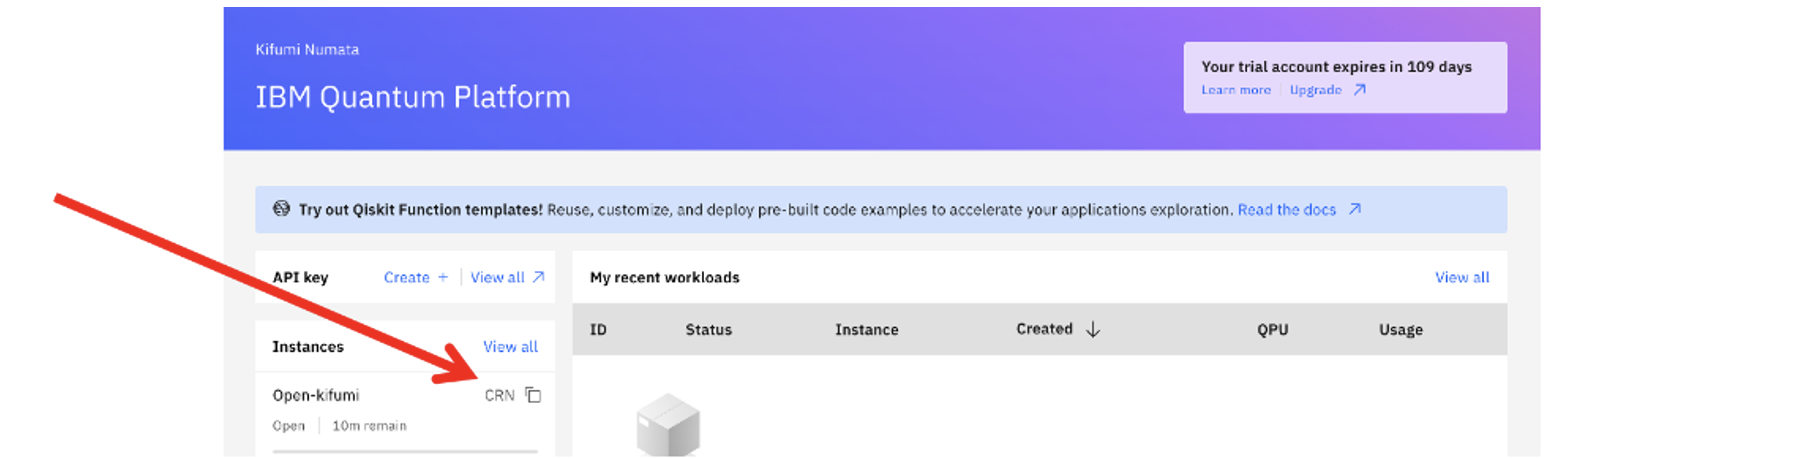

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

your_api_key = "deleteThisAndPasteYourAPIKeyHere"
your_crn = "deleteThisAndPasteYourCRNHere"

service = QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token=your_api_key, 
    instance=your_crn, 
    set_as_default=True, 
    overwrite=True,
)

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
service.backends()

[<IBMBackend('ibm_kingston')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_pittsburgh')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_torino')>]

In [6]:
# 以下でデバイスを指定できます。
backend = service.backend('ibm_brisbane') 

In [7]:
#一番空いているバックエンドを自動的に選択することもできます
backend = service.least_busy(operational=True)
print("最も空いているバックエンドは: ", backend)

最も空いているバックエンドは:  <IBMBackend('ibm_fez')>


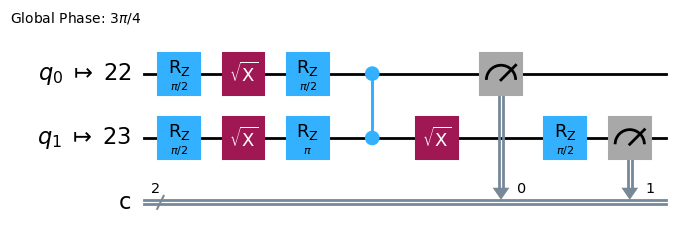

In [9]:
# 実機のバックエンドでの実行に最適な回路にトランスパイルします
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qc)
isa_circuit.draw("mpl", idle_wires=False)

In [10]:
# Samplerで実行します
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend)
job = sampler.run([isa_circuit]) # デフォルトのショット数は4096です

print("job id:", job.job_id()) # 実行に時間がかかるのでjob_idを表示します

job id: d30lk05otchc73baioeg


以下のコマンドでjobのstatus(実行状況)を確認します。

In [11]:
job = service.job(job.job_id()) 
#job = service.job("d2voc9jok8rs73cua4k0") 
job.status() # ジョブの実行状態を確認します

'QUEUED'

In [12]:
# 待ち時間が長い時に後から結果を確認する場合
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()  
job= service.job('d30lk05otchc73baioeg') # 例です。上に出力された自分のjob_idを入れて実行してください。
job.status() # ジョブの実行状態を確認します

'DONE'

上記のセルを何回か実行して、'DONE' が表示されたら、実機での実行が終わっているので、以下のセルを実行して結果を確認します。

In [13]:
### 'DONE'になってから実行します ###
result = job.result()
print(result[0].data.c.get_counts())

{'00': 2067, '11': 1936, '10': 44, '01': 49}


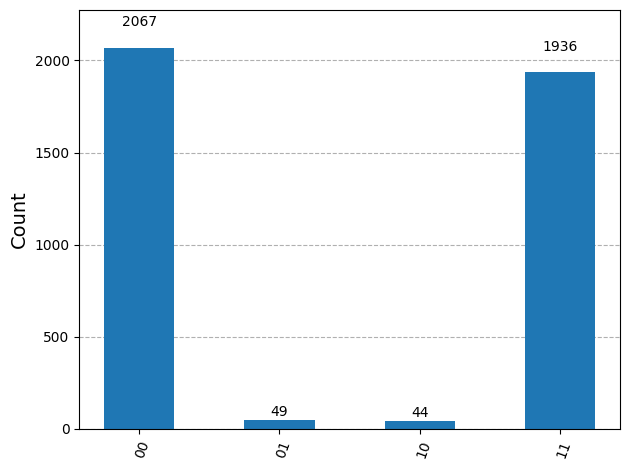

In [14]:
plot_histogram(result[0].data.c.get_counts())

In [15]:
# Qiskitバージョンの確認
import qiskit
qiskit.__version__

'2.1.2'